In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
# !pip install wordcloud==1.8.0
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix

In [6]:
fake_data = pd.read_csv('./Data/Fake.csv')
real_data = pd.read_csv('./Data/True.csv')

fake_data['label'] = 0
real_data['label'] = 1


data = pd.concat([fake_data,real_data]).sample(frac = 1).reset_index(drop=True) # doing random shuffling as well
data.head()

,title,text,subject,date,label
0,Trump Accuses Clinton Of ‘Raping Our Country’,In a statement that was attempting to appeal t...,News,"June 29, 2016",0
1,PROOF THAT TRUMP WAS DEAD ON: NJ Rooftop Parti...,Donald Trump was right again! This is yet anot...,Government News,"Nov 23, 2015",0
2,Trump Just Got Ripped To F*cking Shreds After...,Between Trump s daily tantrums before I ve eve...,News,"January 13, 2017",0
3,"In One GLORIOUS Move, CNN REFUSES To Bow Down...","If there s one thing Donald Trump wants, it s ...",News,"March 6, 2017",0
4,Sean Hannity Is Throwing A Stage-4 Temper Tan...,We re not sure why Fox News host Sean Hannity ...,News,"November 28, 2017",0


In [56]:
data['label'].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

<Axes: xlabel='label'>

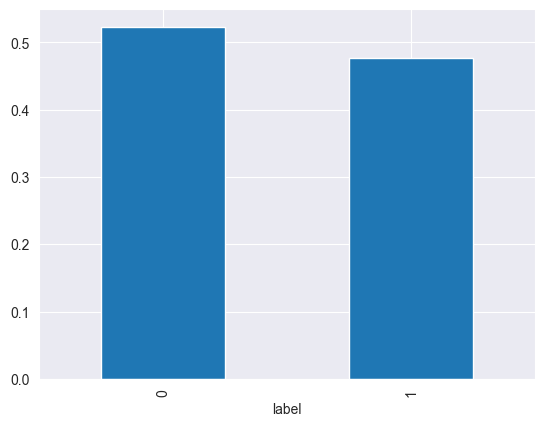

In [57]:
# Checking distribution of real vs fake records

data['label'].value_counts(normalize=True).plot(kind='bar')

- So, dataset is balanced

In [58]:
data.isnull().sum() # No nulll records

title      0
text       0
subject    0
date       0
label      0
dtype: int64

<Axes: xlabel='subject'>

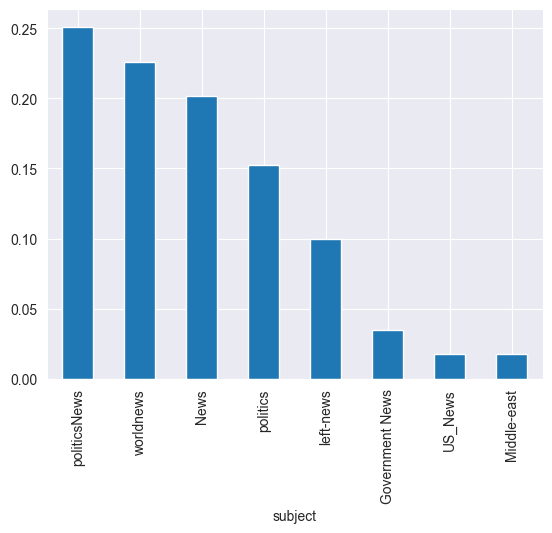

In [59]:
# Examining subject level records and distribution of real vs fake records
data['subject'].value_counts(normalize=True).plot(kind='bar')

- politicsNews (25%), followed by worldnews (close to 23%) have the highest number of records

politicsNews & politics can be combined under same category as represent the same domain for news

In [60]:
data.subject = data.subject.replace({
    'politics': 'PoliticsNews',
    'politicsNews': 'PoliticsNews'
})

/var/folders/yq/7ltbtjt54k7078ql5gkjfxcw0000gp/T/ipykernel_47014/1343942821.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(),rotation=90)


[Text(0, 0, '0'), Text(1, 0, '1')]

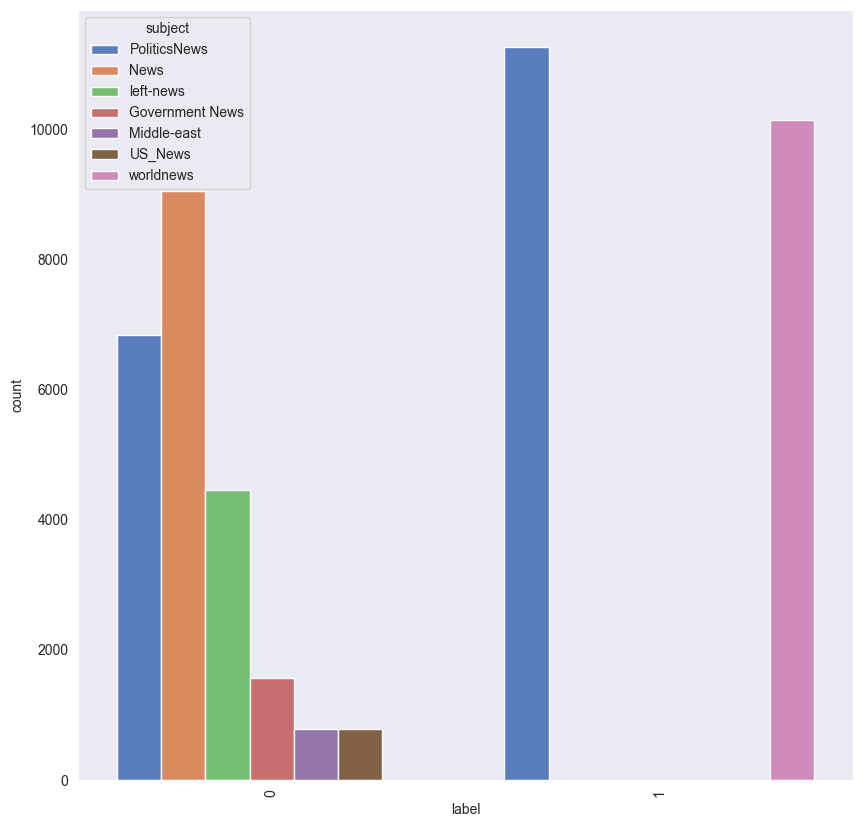

In [61]:
# Digging further to identify the distribution of fake vs real in each subject
plt.figure(figsize = (10,10))
sns.set_style("dark")
chart = sns.countplot(x = "label", hue = "subject" , data = data , palette = 'muted')
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

- It seems all real news belongs to only 2 subjects politicsNews, worldNews.
- we can't use Subject as input feature because it directly defines the label of the news. So which will cause overfitting to the classification model

Checking the prediction accuracy with title only, and with combination of title + content(text)

Lets combine title and text column into one column and drop other columns other than label

In [62]:
data['titleAndtext'] = data['title'] + " " + data['text']
data = data.drop([ 'subject', 'date'], axis=1)

In [63]:
data.head()

,title,text,label,titleAndtext
0,Magnitude 6.0 earthquake hits western Iran: st...,BEIRUT (Reuters) - A magnitude 6.0 earthquake ...,1,Magnitude 6.0 earthquake hits western Iran: st...
1,Goldman's Donovan to withdraw from deputy Trea...,(Reuters) - Goldman Sachs Group Inc banker Jam...,1,Goldman's Donovan to withdraw from deputy Trea...
2,Trump asks Supreme Court to block travel ban r...,WASHINGTON (Reuters) - The U.S. Justice Depart...,1,Trump asks Supreme Court to block travel ban r...
3,U.N. mediator de Mistura to attend Syria talks...,MOSCOW (Reuters) - U.N. special envoy on Syria...,1,U.N. mediator de Mistura to attend Syria talks...
4,Canada bans its agencies from sharing informat...,"OTTAWA (Reuters) - Canada, which has been accu...",1,Canada bans its agencies from sharing informat...


In [1]:
# Lets create a word cloud to analyse the most frequent words in our data.
# from nltk.corpus import stopwords
# from wordcloud import WordCloud

# wordcloud = WordCloud(width=800,
#                       height=800,
#                       background_color='white',
#                       stopwords=stopwords.words('english'),
#                       min_font_size=10)



In [ ]:
# wordcloud = wordcloud.generate(" ".join(data[data['label']==0].text))

In [2]:
# plt.figure(figsize = (8, 8), facecolor = None)
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.tight_layout(pad = 0)
# plt.show()

# Text Preprocessing

In [65]:
stopwords_english = stopwords.words('english')


def text_clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join([
        word for word in text.split()
        if (word not in stopwords_english) and (word not in string.punctuation)
    ])

    return text



In [141]:
# Checking accuracy of prediction only with Title 

In [142]:
# Splitting the data into train and text
X = data["title"].apply(text_clean)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [143]:
classifiers = [
    
    ('MultinomialNB', MultinomialNB()),
    ('RandomForestClassifier', RandomForestClassifier(random_state=0)),
    ('LogisticRegression', LogisticRegression()),
    ('DecisionTreeClassifier',DecisionTreeClassifier(random_state=0)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=0)),
    ('LinearSVC',LinearSVC()),
    ('PassiveAggressiveClassifier',PassiveAggressiveClassifier())
]

In [78]:
#  Define the classifiers
def get_prediction(X_train,y_train, X_test, y_test ):
    
    output = {}

    # Define the pipeline and evaluate each classifier
    for clf_name, clf in classifiers:
        pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', clf)
        ])

        # Train the classifier
        pipe.fit(X_train, y_train)

        # Make predictions
        y_pred = pipe.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Print the results
        output[clf_name] = accuracy
        
    output_df = pd.DataFrame(output.items(), columns=['clf_name','accuracy']).sort_values('accuracy', ascending=False)
    return output_df

def plot_confusion_matrix_report(y_test, prediction):
    
    # printing classification report
    print(classification_report(y_pred, y_test))
    
    # plotting confusion metrix
    cm = metrics.confusion_matrix(y_test, prediction, labels=[0,1])
    
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True)
    plt.show()
    return None

In [145]:
output_df = get_prediction(X_train,y_train, X_test, y_test )
output_df

,clf_name,accuracy
5,LinearSVC,0.946993
2,LogisticRegression,0.942094
1,RandomForestClassifier,0.934165
6,PassiveAggressiveClassifier,0.934076
0,MultinomialNB,0.930958
3,DecisionTreeClassifier,0.895947
4,GradientBoostingClassifier,0.818619


**Observations** Damn! 94.93% accurate prediction is quite a good result (Didn't expect it though :P). 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5949
           1       0.94      0.94      0.94      5276

    accuracy                           0.95     11225
   macro avg       0.95      0.95      0.95     11225
weighted avg       0.95      0.95      0.95     11225



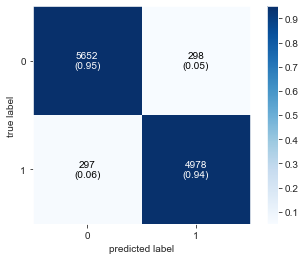

In [146]:
# Lets plot classification report or confusion metrics for highest accuracy classifier

pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('LinearSVC', LinearSVC())
        ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
plot_confusion_matrix_report(y_test,y_pred)

In [147]:
# Checking accuracy of prediction with Title + Text

In [70]:
# Splitting the data into train and text
X = data["titleAndtext"].apply(text_clean)
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [149]:
output_df = get_prediction(X_train,y_train, X_test, y_test )
output_df

,clf_name,accuracy
3,DecisionTreeClassifier,0.997506
4,GradientBoostingClassifier,0.996526
6,PassiveAggressiveClassifier,0.995546
5,LinearSVC,0.995457
1,RandomForestClassifier,0.994120
2,LogisticRegression,0.986637
0,MultinomialNB,0.937194


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5914
           1       0.99      1.00      1.00      5311

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



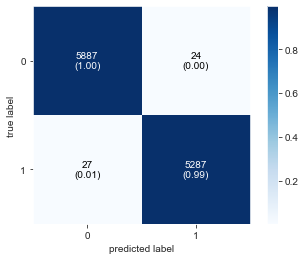

In [150]:
# Lets plot classification report or confusion metrics for highest accuracy classifier

pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('LinearSVC', LinearSVC())
        ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
plot_confusion_matrix_report(y_test,y_pred)


### Using word embeddings

In [66]:
from gensim.models import Word2Vec, KeyedVectors

In [67]:
word2vec_embeddings = KeyedVectors.load_word2vec_format('./NLP Projects/GoogleNews-vectors-negative300.bin', binary = True)


In [68]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s, embeddings):
#     words = str(s).lower().decode('utf-8')
    words = set(nltk.word_tokenize(s))
    words = [w for w in words if not w in stopwords_english]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [72]:
sent2vec(X_train[0], word2vec_embeddings)

array([ 8.29986471e-04,  2.21653990e-02,  4.32379469e-02,  4.50510867e-02,
       -4.11034748e-03, -7.94541277e-03, -2.14927178e-02, -1.59460887e-01,
        9.37015414e-02,  1.06352106e-01, -1.86343342e-02, -1.50333107e-01,
        3.35109606e-02,  1.37035735e-02, -1.30267516e-02,  2.14326922e-02,
       -9.37367231e-02,  6.93023205e-02,  2.03501917e-02, -8.17567706e-02,
       -2.74930429e-02, -8.21293332e-03, -9.16503742e-03, -1.71616785e-02,
        4.97588255e-02, -8.37955177e-02, -2.83457972e-02,  2.88104657e-02,
        2.70625260e-02, -1.16338849e-01,  1.36026712e-02, -3.25239301e-02,
       -8.25125724e-02, -2.76662596e-02, -1.99238155e-02, -4.22641113e-02,
       -3.63773666e-02,  1.42650045e-02,  1.02615096e-02,  1.71542272e-01,
        1.17150205e-03, -6.02392182e-02,  1.22188598e-01,  1.15086883e-02,
        3.53132337e-02,  1.43374475e-02, -3.90380807e-02,  3.44827306e-03,
       -7.19889104e-02,  3.76829505e-02,  5.56980930e-02,  4.63053808e-02,
        4.60611433e-02,  

In [73]:
from tqdm import tqdm

In [74]:
X_train_word2vec = [sent2vec(x,word2vec_embeddings) for x in tqdm(X_train.values)]
X_test_word2vec = [sent2vec(x,word2vec_embeddings) for x in tqdm(X_test.values)]

100%|█████████████████████████████████████████████████████| 11225/11225 [00:09<00:00, 1177.47it/s]


In [75]:
X_train_word2vec = np.array(X_train_word2vec)
X_test_word2vec = np.array(X_test_word2vec)

In [76]:
y_train_word2vec = np.array(y_train)
y_test_word2vec = np.array(y_test)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5755
           1       0.96      0.95      0.96      5470

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



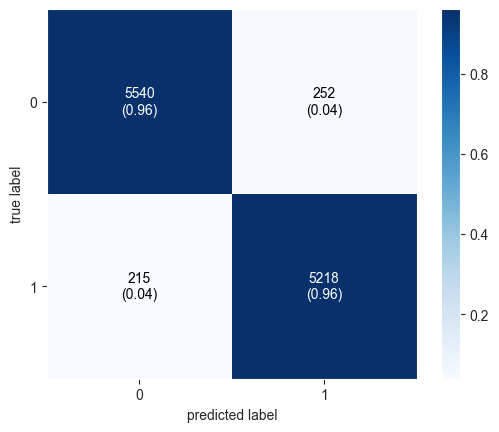

In [79]:
# Fitting a simple Logistic Regression on Word2Vec features

LR = LogisticRegression()
LR.fit(X_train_word2vec, y_train_word2vec)
y_pred = LR.predict(X_test_word2vec)
plot_confusion_matrix_report(y_test_word2vec,y_pred)

# clf = xgb.XGBClassifier(nthread=10, silent=False)
# clf.fit(xtrain_glove, ytrain)
# predictions = clf.predict_proba(xvalid_glove)

In [80]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_embeddings = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            try:
                embedding = np.array(split_line[1:], dtype=np.float64)
                glove_embeddings[word] = embedding
            except:
                pass
            
    print(f"{len(glove_embeddings)} words loaded!")
    return glove_embeddings

In [81]:
glove_embeddings = load_glove_model('./NLP Projects/glove.840B.300d.txt')

Loading Glove Model
2195884 words loaded!


In [82]:
X_train_glove = [sent2vec(x,glove_embeddings) for x in tqdm(X_train.values)]
X_test_glove = [sent2vec(x,glove_embeddings) for x in tqdm(X_test.values)]

100%|█████████████████████████████████████████████████████| 11225/11225 [00:09<00:00, 1206.58it/s]


In [83]:
X_train_glove = np.array(X_train_glove)
X_test_glove = np.array(X_test_glove)

In [102]:
y_train_glove.shape

(33673,)

In [84]:
y_train_glove = np.array(y_train)
y_test_glove = np.array(y_test)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      5781
           1       0.94      0.94      0.94      5444

    accuracy                           0.94     11225
   macro avg       0.94      0.94      0.94     11225
weighted avg       0.94      0.94      0.94     11225



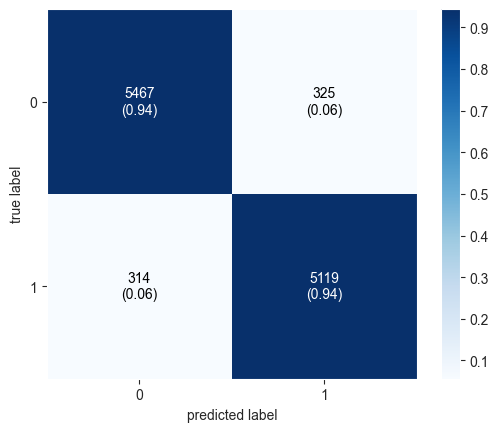

In [85]:
# Fitting a simple Logistic Regression on Word2Vec features

LR = LogisticRegression()
LR.fit(X_train_glove, y_train_glove)
y_pred = LR.predict(X_test_glove)
plot_confusion_matrix_report(y_test_glove,y_pred)

# clf = xgb.XGBClassifier(nthread=10, silent=False)
# clf.fit(xtrain_glove, ytrain)
# predictions = clf.predict_proba(xvalid_glove)

## Deep Learning

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import to_categorical

In [120]:
from keras.preprocessing import sequence, text

In [86]:
# scale the data before any neural net:
from sklearn import preprocessing
scl = preprocessing.StandardScaler()
X_train_glove_scl = scl.fit_transform(X_train_glove)
X_test_glove_scl = scl.transform(X_test_glove)

In [104]:
y_train_glove_enc[0]

array([0., 1.], dtype=float32)

In [139]:
# we need to binarize the labels for the neural net
y_train_glove_enc = to_categorical(y_train_glove,2)
y_test_glove_enc = to_categorical(y_test_glove,2)

In [140]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [141]:
model.fit(X_train_glove_scl, 
          y=y_train_glove_enc, 
          batch_size=64, 
          epochs=5, 
          verbose=1, 
          validation_data = (X_test_glove_scl, 
                             y_test_glove_enc))


Epoch 1/5
527/527 [==============================] - 10s 17ms/step - loss: 0.1590 - val_loss: 0.1110
Epoch 2/5
527/527 [==============================] - 8s 16ms/step - loss: 0.1269 - val_loss: 0.0901
Epoch 3/5
527/527 [==============================] - 8s 16ms/step - loss: 0.1226 - val_loss: 0.0980
Epoch 4/5
527/527 [==============================] - 8s 16ms/step - loss: 0.1180 - val_loss: 0.0990
Epoch 5/5
527/527 [==============================] - 8s 16ms/step - loss: 0.1188 - val_loss: 0.0912


In [142]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test_glove_scl)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f"Accuracy: {accuracy}")

351/351 [==============================] - 1s 2ms/step
Accuracy: 0.9684632516703786


In [143]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(X_train) + list(X_test))
X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

In [148]:
# Zero pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

word_index = token.word_index

In [145]:
# Creating embedding matrix for the words in the data set
embedding_matrix = np.zeros((len(word_index) + 1, 300))

for word, i in tqdm(word_index.items()):
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|█████████████████████████████████████████████████| 106160/106160 [00:00<00:00, 240657.46it/s]


In [136]:
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

In [146]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()

# Embedding is used for converting integer indices to dense vector of fixed size
model.add(Embedding(len(word_index) + 1, # input dimension, representing vocabulary size
                    300, # output dimension, size of dense embedding
                    weights = [embedding_matrix], #initializes the embedding layer with pre-trained word embeddings like word2vec or glove
                    input_length = max_len, # len of input sequence
                    trainable=False # Freezes the embedding layer during training, meaning trained word embedding won't be updated
                   ))
model.add(SpatialDropout1D(0.3)) # to prevent overfitting by randomly setting fraction of input units to zero at each update during training. o.3 is dropout rate.

model.add(LSTM(100, # layer with 100 units
               dropout=0.3,  # dropout rate for input units
               recurrent_dropout=0.3 # dropout rate for recurrent units
              ))

# Defining two fully connected (dense) layers with 1024 units and ReLU activation function
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8)) # dropout rate for each dense layer

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

# Final Dense Layer with 2 units representing no. of output classes
model.add(Dense(2))
# Softmax activation used for multiclass classification
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [154]:
model.fit(X_train_pad,
          y = y_train_glove_enc,
          batch_size=1000, #determines the number of samples that will be used in each iteration of training. 
          epochs=10, # 1 epoch is one complete pass through the entire training dataset.
          verbose=1, # progress bars will be displayed for each epoch.
          validation_data = (X_test_pad, y_test_glove_enc) # evaluated against test data
         )

Epoch 1/10
34/34 [==============================] - 261s 8s/step - loss: 0.1901 - val_loss: 0.1471
Epoch 2/10
34/34 [==============================] - 331s 10s/step - loss: 0.1636 - val_loss: 0.1577
Epoch 3/10
34/34 [==============================] - 401s 12s/step - loss: 0.1497 - val_loss: 0.1636
Epoch 4/10
34/34 [==============================] - 497s 15s/step - loss: 0.1379 - val_loss: 0.1425
Epoch 5/10
34/34 [==============================] - 613s 18s/step - loss: 0.1330 - val_loss: 0.1374
Epoch 6/10
34/34 [==============================] - 542s 16s/step - loss: 0.1209 - val_loss: 0.1360
Epoch 7/10
34/34 [==============================] - 460s 13s/step - loss: 0.1163 - val_loss: 0.1287
Epoch 8/10
34/34 [==============================] - 431s 13s/step - loss: 0.1096 - val_loss: 0.1360
Epoch 9/10
34/34 [==============================] - 406s 12s/step - loss: 0.1033 - val_loss: 0.1109
Epoch 10/10
34/34 [==============================] - 3218s 97s/step - loss: 0.0975 - val_loss: 0.1281

In [156]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, np.argmax(y_pred, axis=1))
print(f"Accuracy: {accuracy}")

351/351 [==============================] - 82s 233ms/step
Accuracy: 0.955902004454343


In [ ]:
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss',  # metric to be monitored for early stopping
                          min_delta=0.01, # min change in the metric to qualify as improvement
                          patience=3, # no. of consecutive epochs with no improvement after which training will stopped
                          verbose=0,
                          mode='auto' # automatically infer the direction based on monitored metric. Like here for val_loss it should be decreasing.
                         )

model.fit(X_train_pad,
          y = y_train_glove_enc,
          batch_size=100, #determines the number of samples that will be used in each iteration of training. 
          epochs=10, # 1 epoch is one complete pass through the entire training dataset.
          verbose=1, # progress bars will be displayed for each epoch.
          validation_data = (X_test_pad, y_test_glove_enc) # evaluated against test data
          callbacks=[earlystop]
         )

In [ ]:
# A simple Bi-directional LSTM with glove embeddings and 2 dense layers

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(300, 
                             dropout=0.3, 
                             recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(X_train_pad,
          y = y_train_glove_enc,
          batch_size=100, #determines the number of samples that will be used in each iteration of training. 
          epochs=10, # 1 epoch is one complete pass through the entire training dataset.
          verbose=1, # progress bars will be displayed for each epoch.
          validation_data = (X_test_pad, y_test_glove_enc) # evaluated against test data
          callbacks=[earlystop]
         )

In [ ]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    300,
                    weights = [embedding_matrix],
                    input_length = max_len,
                    trainable= False                   
                   ))

model.add(SpatialDropout1D(0.3))

model.add(GRU(300,
              dropout=0.3,
              recurrent_dropout=0.3,
              return_sequences=True # returns the full sequence of outputs for each input sequence.
             ))
model.add(GRU(300,
              droput=0.3, 
              recurrent_dropout=0.3
             ))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')



In [ ]:
model.fit(X_train_pad,
          y = y_train_glove_enc,
          batch_size=100, #determines the number of samples that will be used in each iteration of training. 
          epochs=10, # 1 epoch is one complete pass through the entire training dataset.
          verbose=1, # progress bars will be displayed for each epoch.
          validation_data = (X_test_pad, y_test_glove_enc) # evaluated against test data
          callbacks=[earlystop]
         )